# Face Generation Using DCGAN

## 1.0. Introduction
In this project, we'll define and train a Deep Convolutional Generative Adversarial Neural Networks (DCGAN) on a dataset of faces. Our goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, we'll be able to visualize the results of our trained Generator to see how it performs; our generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

We'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train our adversarial networks.

### Pre-processed Data

Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> We can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

The data is put on the directory `processed_celeba_small/`.

In [2]:
data_dir = 'processed_celeba_small/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

#import helper

%matplotlib inline

---
## 2.0. Create a DataLoader and Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since we're going to be generating faces, we won't need the annotations, we'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

Our images should be square, Tensor images of size `image_size x image_size` in the x and y dimension. To create a dataset given a directory of images, we use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import os
import torch
from torchvision import datasets
from torchvision import transforms

In [7]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    files = os.path.join(data_dir, 'celeba/')
    
    data_transforms = transforms.Compose([transforms.Resize(image_size), 
                                          transforms.ToTensor()])
    
    data = datasets.ImageFolder(files, transform=data_transforms)
    
    loader = torch.utils.data.DataLoader(data, 
                                         batch_size=batch_size, 
                                         shuffle=True)
    
    return loader


We call the above function and create a dataloader to view images. We can decide on any reasonable `batch_size` parameter. The `image_size` is set to `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces.

In [8]:
# Define function hyperparameters
batch_size = 50
img_size = 32

# Call the function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, we can view some images. We should see square images of somewhat-centered faces.

Note: We'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

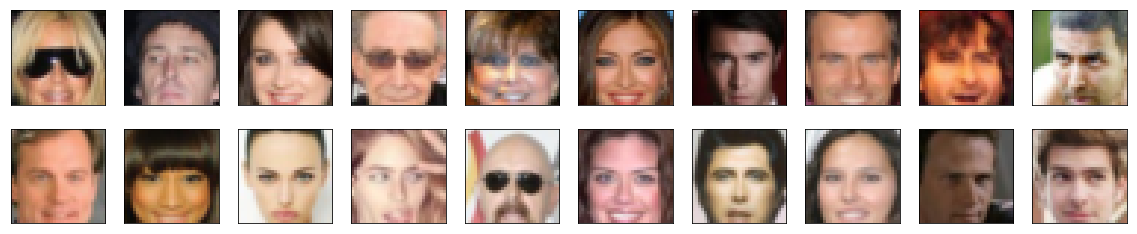

In [9]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

### Pre-process the image data and scale it to a pixel range of -1 to 1

We need to do a bit of pre-processing; we know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [10]:
# Scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min_, max_ = feature_range
    x = x * (max_ - min_) + min_
    return x


In [11]:
# scale the images
img = images[0]
scaled_img = scale(img)

# check scaled range
# should be close to -1 to 1
print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9608)
Max:  tensor(0.9373)


---
## 3.0. Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

### 3.1. Discriminator

First, we will define the discriminator. This is a normal convolutional classifier, only without any maxpooling layers. To deal with this complex data, we use a deep network with **normalization**. 
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [1]:
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [3]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # convolutional layers
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        
        # fully connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # convolutional layers
        x = F.leaky_relu( self.conv1(x), 0.2)
        x = F.leaky_relu( self.conv2(x), 0.2)
        x = F.leaky_relu( self.conv3(x), 0.2)
        
        # flatten
        x = x.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        x = self.fc(x)
        
        return x


### 3.2. Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [4]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """

    ## create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, 
                                              stride, padding, bias=False)
    
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [5]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # fully connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        # transpose convolutional layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # fully connected + reshape
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        
        # last layer + tanh activation
        x = self.t_conv3(x)
        x = F.tanh(x)
        
        return x


### 3.3. Initialize the weights of our networks

To help our models converge, we initialize the weights of the convolutional and linear layers in our model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

We define `weights_init_normal` to initialize the weigths of the networks. 
* This function initializes only **convolutional** and **linear** layers
* This function initializes the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [17]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        m.weight.data.normal_(0.0, 0.02)
        
        # The bias terms, if they exist, set to 0
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data.zero_()


### 3.4. Build complete network

We define our models' hyperparameters and instantiate the discriminator and generator from the classes defined above.

In [18]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


In [19]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

# Create discriminator and generator
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

### 3.5. Training on GPU

We check if we can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. 

In [20]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a CPU to train the neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## 4.0. Discriminator and Generator Losses

Now, we need to calculate the losses for both types of adversarial networks.

### 4.1. Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### 4.2. Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

In [21]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

### 4.3. Optimizers
We define optimizers for our models with appropriate hyperparameters.

In [22]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## 5.0. Training

Training will involve alternating between training the discriminator and the generator. We'll use the functions `real_loss` and `fake_loss` to help calculate the discriminator losses.

* We train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and has an opposing loss function

In [23]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #                TRAIN THE NETWORKS
            # ===============================================
            
            d_optimizer.zero_grad()
            
            # 1. Train the discriminator on real and fake images
            if train_on_gpu:
                real_images = real_images.cuda()
            
            # Compute the discriminator losses on real images 
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
        
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
        
            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels
        
            # perform backprop
            g_loss.backward()
            g_optimizer.step()

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))

        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set our number of training epochs and train our DCGAN.

In [24]:
# set number of epochs 
n_epochs = 25

# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   25] | d_loss: 1.5945 | g_loss: 0.7962
Epoch [    1/   25] | d_loss: 0.1225 | g_loss: 4.3934
Epoch [    1/   25] | d_loss: 0.2583 | g_loss: 3.7896
Epoch [    1/   25] | d_loss: 0.5231 | g_loss: 1.9207
Epoch [    1/   25] | d_loss: 0.3860 | g_loss: 2.2445
Epoch [    1/   25] | d_loss: 0.8604 | g_loss: 0.7572
Epoch [    1/   25] | d_loss: 0.7853 | g_loss: 1.2067
Epoch [    1/   25] | d_loss: 0.6084 | g_loss: 2.4156
Epoch [    1/   25] | d_loss: 1.2523 | g_loss: 0.5611
Epoch [    1/   25] | d_loss: 1.1282 | g_loss: 3.1600
Epoch [    1/   25] | d_loss: 0.7247 | g_loss: 2.4438
Epoch [    1/   25] | d_loss: 0.9899 | g_loss: 1.0115
Epoch [    1/   25] | d_loss: 1.0313 | g_loss: 1.6850
Epoch [    1/   25] | d_loss: 1.0298 | g_loss: 0.9632
Epoch [    1/   25] | d_loss: 1.0296 | g_loss: 1.5257
Epoch [    1/   25] | d_loss: 0.9531 | g_loss: 1.2276
Epoch [    1/   25] | d_loss: 0.9406 | g_loss: 1.1895
Epoch [    1/   25] | d_loss: 0.9709 | g_loss: 1.2199
Epoch [    1/   25] | d_loss

Epoch [    7/   25] | d_loss: 1.4869 | g_loss: 3.2777
Epoch [    7/   25] | d_loss: 0.9364 | g_loss: 1.3954
Epoch [    7/   25] | d_loss: 0.6432 | g_loss: 1.8053
Epoch [    7/   25] | d_loss: 1.0412 | g_loss: 2.0565
Epoch [    7/   25] | d_loss: 1.0143 | g_loss: 0.9893
Epoch [    7/   25] | d_loss: 0.7990 | g_loss: 1.4075
Epoch [    7/   25] | d_loss: 0.8518 | g_loss: 1.5356
Epoch [    7/   25] | d_loss: 1.1061 | g_loss: 1.5474
Epoch [    7/   25] | d_loss: 0.7931 | g_loss: 1.2871
Epoch [    8/   25] | d_loss: 0.9240 | g_loss: 1.2701
Epoch [    8/   25] | d_loss: 1.0391 | g_loss: 1.2757
Epoch [    8/   25] | d_loss: 0.9587 | g_loss: 1.3271
Epoch [    8/   25] | d_loss: 1.2180 | g_loss: 2.3374
Epoch [    8/   25] | d_loss: 0.7281 | g_loss: 1.7600
Epoch [    8/   25] | d_loss: 0.9698 | g_loss: 1.9074
Epoch [    8/   25] | d_loss: 0.8888 | g_loss: 1.2268
Epoch [    8/   25] | d_loss: 1.1709 | g_loss: 0.5714
Epoch [    8/   25] | d_loss: 1.0657 | g_loss: 0.7940
Epoch [    8/   25] | d_loss

Epoch [   14/   25] | d_loss: 0.5717 | g_loss: 0.8224
Epoch [   14/   25] | d_loss: 0.5490 | g_loss: 2.1865
Epoch [   14/   25] | d_loss: 0.2355 | g_loss: 2.3081
Epoch [   14/   25] | d_loss: 0.3254 | g_loss: 2.4408
Epoch [   14/   25] | d_loss: 0.4921 | g_loss: 1.7550
Epoch [   14/   25] | d_loss: 0.4639 | g_loss: 1.7745
Epoch [   14/   25] | d_loss: 0.3924 | g_loss: 2.0972
Epoch [   14/   25] | d_loss: 0.4873 | g_loss: 2.2452
Epoch [   14/   25] | d_loss: 0.3915 | g_loss: 3.2779
Epoch [   14/   25] | d_loss: 0.8290 | g_loss: 1.9619
Epoch [   14/   25] | d_loss: 0.4005 | g_loss: 2.1903
Epoch [   14/   25] | d_loss: 0.3162 | g_loss: 3.1627
Epoch [   14/   25] | d_loss: 0.2525 | g_loss: 1.4151
Epoch [   14/   25] | d_loss: 0.3003 | g_loss: 2.6098
Epoch [   14/   25] | d_loss: 0.4300 | g_loss: 2.9016
Epoch [   14/   25] | d_loss: 0.2969 | g_loss: 1.9295
Epoch [   14/   25] | d_loss: 0.4591 | g_loss: 2.7087
Epoch [   14/   25] | d_loss: 0.3949 | g_loss: 2.2191
Epoch [   15/   25] | d_loss

Epoch [   20/   25] | d_loss: 0.3541 | g_loss: 2.6786
Epoch [   20/   25] | d_loss: 0.3435 | g_loss: 2.5385
Epoch [   20/   25] | d_loss: 0.4601 | g_loss: 3.4482
Epoch [   20/   25] | d_loss: 0.2170 | g_loss: 4.1303
Epoch [   21/   25] | d_loss: 0.4995 | g_loss: 1.0583
Epoch [   21/   25] | d_loss: 0.2488 | g_loss: 2.1093
Epoch [   21/   25] | d_loss: 0.2742 | g_loss: 2.3492
Epoch [   21/   25] | d_loss: 0.2512 | g_loss: 2.0743
Epoch [   21/   25] | d_loss: 0.2049 | g_loss: 3.2166
Epoch [   21/   25] | d_loss: 0.2779 | g_loss: 3.2486
Epoch [   21/   25] | d_loss: 0.3532 | g_loss: 3.8282
Epoch [   21/   25] | d_loss: 1.6753 | g_loss: 0.5933
Epoch [   21/   25] | d_loss: 0.2365 | g_loss: 3.0077
Epoch [   21/   25] | d_loss: 0.2253 | g_loss: 3.7239
Epoch [   21/   25] | d_loss: 0.2819 | g_loss: 2.4195
Epoch [   21/   25] | d_loss: 0.1911 | g_loss: 2.1800
Epoch [   21/   25] | d_loss: 0.4367 | g_loss: 3.3150
Epoch [   21/   25] | d_loss: 0.3742 | g_loss: 2.5929
Epoch [   21/   25] | d_loss

### 5.1. Training loss

We plot the training losses for the generator and discriminator, recorded after each epoch.

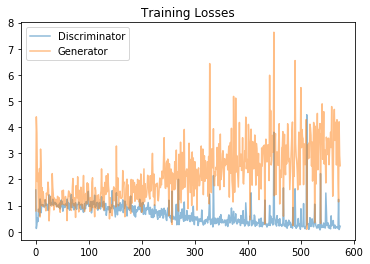

In [25]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### 5.2. Generator samples from training

View samples of images from the generator.

In [26]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [27]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

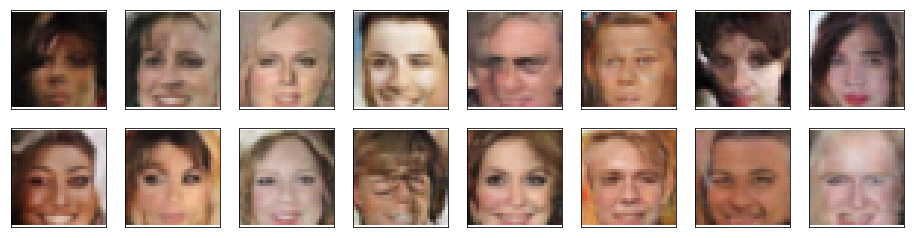

In [28]:
_ = view_samples(-1, samples)